In [173]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

from utils import training_curve_plot
from utils import load_mnist

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torchvision.transforms import v2 as T
from torch.utils.data import TensorDataset, DataLoader

In [174]:
np.random.seed(666)

In [175]:
X_train, Y_train, X_test, Y_test = load_mnist()

In [176]:
Y_train.shape

(60000, 10)

In [177]:
X_train_tensors = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensors  = torch.tensor(Y_train, dtype=torch.float32)

X_test_tensors  = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensors  = torch.tensor(Y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensors , Y_train_tensors )
test_dataset = TensorDataset(X_test_tensors , Y_test_tensors )

In [178]:
# extract a complete PyTorch dataset
def extract(dataset):
    datasize = len(dataset)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=datasize, shuffle=False)
    return next(iter(dataloader))

In [179]:
X_train_tensors.shape

torch.Size([60000, 784])

In [180]:
X,Y = train_dataset.tensors
Y.shape

torch.Size([60000, 10])

## Exercise 1: Multi-layer fully-connected neural network

#### Utilities

In [181]:
def weight_init(net_l):
    # network initialization function
    if not isinstance(net_l, list):
        net_l = [net_l]
    for net in net_l:
        for m in net.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                m.bias.data.fill_(0.0)

class Net(nn.Module):
    def __init__(self, activation="sigmoid"):
        super(Net, self).__init__()
        U1 = 250 # number of unit for hidden layer 1

        self.fc1 = nn.Linear(784, U1)
        self.h1 = nn.Linear(U1, U1)
        self.h2 = nn.Linear(U1, U1)
        #self.h3 = nn.Linear(U1, U1)
        #self.h4 = nn.Linear(U1, U1)
        self.fc2 = nn.Linear(U1, 10)

        # define the activation function
        if activation == "sigmoid":
            self.activate = nn.Sigmoid()
        elif activation == "relu":
            self.activate = nn.ReLU()

        # network initialization
        self.apply(weight_init)

    def forward(self, input):
        # flatten the data into a matrix with 28 x 28 = 784 columns
        x = input.view(-1, 784)

        x1 = self.activate(self.fc1(x))
        x2 = self.activate(self.h1(x1))
        x3 = self.activate(self.h2(x2))

        x4 = self.fc2(x3)

        return x4

In [182]:
def cross_entropy(G, Y):
    loss = F.cross_entropy(G, Y)
    return loss

In [183]:
def predict(net, X):
    return net(X).argmax(dim=1)

def accuracy(G, Y):
    return (G.argmax(dim=1) == Y.argmax(dim=1)).float().mean()

In [184]:
print("Use GPU: ", torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Use GPU:  False


In [185]:
class TrainedModel:
    def __init__(self,model, train_acc, test_acc, train_cost, test_cost, elapsed, epochs, batch_size, lr):
        self.model = model
        self.train_acc = train_acc
        self.test_acc = test_acc
        self.train_cost = train_cost
        self.test_cost = test_cost
        self.elapsed = elapsed
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr


    def plot_loss_cost(self,title):
        
        training_curve_plot(title,
                        self.train_cost, 
                        self.test_cost, 
                        self.train_acc, 
                        self.test_acc,
                        self.batch_size, 
                        self.lr, 
                        self.epochs, 
                        self.elapsed)
        return 0
    
    
    def plot_predictions(self, testset, n):

        # evaluate the network on 100 random test images
        with torch.no_grad():
            # obtain 100 random samples from the test data set
            random_X, random_Y = next(iter(torch.utils.data.DataLoader(testset, batch_size=n, shuffle=True)))

            # move data to the GPU if needed
            random_X, random_Y = random_X.to(device), random_Y.to(device)

            # compute the predictions for the sampled inputs
            random_Yhat = predict(self.model, random_X)

            # sort the predictions with the incorrect ones first
            indices_incorrect_first = (random_Yhat == random_Y.argmax(dim=1)).float().argsort()

        # plot the images
        num_rows = 10
        num_cols = 10
        num_images = num_rows * num_cols
        plt.figure(figsize=(num_cols, num_rows))

        for i, index in enumerate(indices_incorrect_first, 1):
            plt.subplot(num_rows, num_cols, i)
            plt.xticks([])
            plt.yticks([])

            # plot the image
            plt.imshow(random_X[index, :].view(28, 28).cpu().numpy(), cmap=plt.cm.binary)

            # add the prediction as annotation (incorrect predictions in red, correct ones in blue)
            color = 'blue' if random_Yhat[index] == random_Y[index].argmax() else 'red'
            plt.text(0, 25, random_Yhat[index].item(), fontsize=25, color=color)

        plt.show()


    def plot_confusion_matrix(self, testset):

        with torch.no_grad():
            test_X, test_Y = extract(testset)
            y_preds = predict(self.model, test_X.to(device)).cpu().numpy()
            y_labels = test_Y.to(device).cpu().numpy()

        class_names = np.arange(10) # for MNIST labels
        cm = confusion_matrix(y_labels.argmax(1), y_preds).astype(np.float64)

        plt.figure(figsize=(6, 6))
        plt.imshow(cm, interpolation='nearest', cmap='viridis')
        plt.title("Confusion Matrix")
        plt.colorbar(shrink=0.75, fraction=0.05)

        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)

        plt.xlabel("Predicted label")
        plt.ylabel("True label")

        plt.tight_layout()
        plt.show()
    

#### Training

In [186]:
def train_model(model, learning_rate, batch_size, num_epochs, trainset, testset, device='cpu', optimizer = "SGD"):
    # initialize the test and training error statistics
    test_acc = []
    test_cost = []
    test_iter = []
    train_acc = []
    train_cost = []

    test_X, test_Y = extract(testset)


    # initialize the neural network and move it to the GPU if needed
    model.to(device)
    model.train(True)

    # define the optimization algorithm
    if optimizer=="SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    else:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # define the data loader for batches of the training data
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=2, shuffle=True)

    t = 0 # current iteration
    done = False
    start_time = time.time()

    # Training loop
    for epoch in tqdm(range(num_epochs), desc="Training"):
        for (batch_X, batch_Y) in trainloader:

            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device) # move batch to the GPU if needed

            optimizer.zero_grad() # reset the gradients back to zero
            out = model(batch_X)

            loss = cross_entropy(out,batch_Y)
            loss.backward()
            optimizer.step() # Adjust learning weights


            # don't bother too much about the following lines!
            # Set the model to evaluation mode, disabling dropout and using population
            # statistics for batch normalization.
            model.eval()

            with torch.no_grad():
                # evaluate the performance on the training data at every 100th iteration
                if t % 100 == 0:
                    train_cost.append(loss.item())
                    train_acc.append(accuracy(out, batch_Y).item())

                # evaluate the performance on the test data at every 100th iteration
                if t % 100 == 0:
                    # move test data to the GPU if needed
                    X, Y = test_X.to(device), test_Y.to(device)

                    # compute predictions for the test data
                    G = model(X)
                    test_cost.append(cross_entropy(G, Y).item())
                    test_acc.append(accuracy(G, Y).item())
                    test_iter.append(t)

                    # print the iteration number and the accuracy of the predictions
                    print(f"Epoch {epoch:2d} - Step {t:5d}: train accuracy {100 * train_acc[-1]:6.2f}% " \
                        f"train costs {train_cost[-1]:5.2f}  " \
                        f"test accuracy {100 * test_acc[-1]:6.2f}% " \
                        f"test costs {test_cost[-1]:5.2f}")

            # accumulate iterations
            t += 1

    end_time = time.time()
    elapsed = end_time - start_time

    #return model, train_acc, test_acc, train_cost, test_cost, elapsed
    return TrainedModel(
                    model,
                    train_acc,
                    test_acc,
                    train_cost,
                    test_cost,
                    elapsed,
                    num_epochs,
                    batch_size,
                    learning_rate
                )




In [187]:
learning_rate = 0.01
epochs = 2
batch_size = 32

model = Net(activation="relu")

model_base = train_model(model,
                        learning_rate,
                        batch_size,
                        epochs,
                        train_dataset,
                        test_dataset,
                        device='cpu')

#model_1_trained, train_acc, test_acc, train_cost, test_cost, elapsed = 

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  0 - Step     0: train accuracy  12.50% train costs  2.44  test accuracy   9.87% test costs  2.36
Epoch  0 - Step   100: train accuracy  81.25% train costs  0.55  test accuracy  85.09% test costs  0.49
Epoch  0 - Step   200: train accuracy  81.25% train costs  0.51  test accuracy  91.55% test costs  0.29
Epoch  0 - Step   300: train accuracy  90.62% train costs  0.55  test accuracy  88.80% test costs  0.34
Epoch  0 - Step   400: train accuracy  93.75% train costs  0.14  test accuracy  93.54% test costs  0.22
Epoch  0 - Step   500: train accuracy  93.75% train costs  0.16  test accuracy  93.65% test costs  0.20
Epoch  0 - Step   600: train accuracy  96.88% train costs  0.14  test accuracy  94.49% test costs  0.18
Epoch  0 - Step   700: train accuracy  93.75% train costs  0.17  test accuracy  94.37% test costs  0.19
Epoch  0 - Step   800: train accuracy  93.75% train costs  0.17  test accuracy  95.19% test costs  0.16
Epoch  0 - Step   900: train accuracy  90.62% train costs  0.17 

Training:  50%|█████     | 1/2 [00:42<00:42, 42.86s/it]

Epoch  1 - Step  1900: train accuracy 100.00% train costs  0.05  test accuracy  96.66% test costs  0.10
Epoch  1 - Step  2000: train accuracy  96.88% train costs  0.11  test accuracy  95.91% test costs  0.13
Epoch  1 - Step  2100: train accuracy 100.00% train costs  0.02  test accuracy  96.29% test costs  0.12
Epoch  1 - Step  2200: train accuracy  96.88% train costs  0.08  test accuracy  96.46% test costs  0.11
Epoch  1 - Step  2300: train accuracy  96.88% train costs  0.08  test accuracy  96.09% test costs  0.13
Epoch  1 - Step  2400: train accuracy 100.00% train costs  0.04  test accuracy  96.25% test costs  0.12
Epoch  1 - Step  2500: train accuracy  93.75% train costs  0.29  test accuracy  96.69% test costs  0.11
Epoch  1 - Step  2600: train accuracy 100.00% train costs  0.05  test accuracy  96.81% test costs  0.10
Epoch  1 - Step  2700: train accuracy 100.00% train costs  0.04  test accuracy  96.92% test costs  0.10
Epoch  1 - Step  2800: train accuracy 100.00% train costs  0.01 

Training: 100%|██████████| 2/2 [01:13<00:00, 36.56s/it]


0

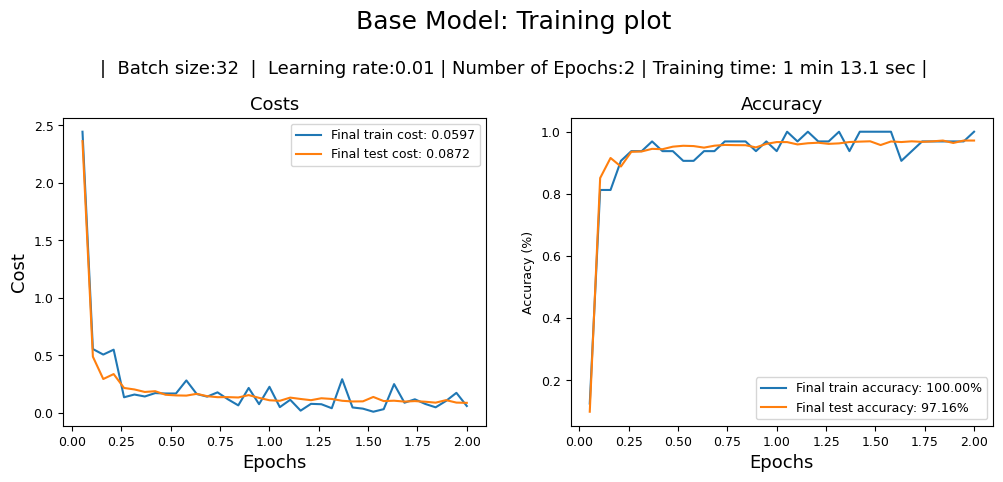

In [188]:
model_base.plot_loss_cost("Base Model: Training plot")

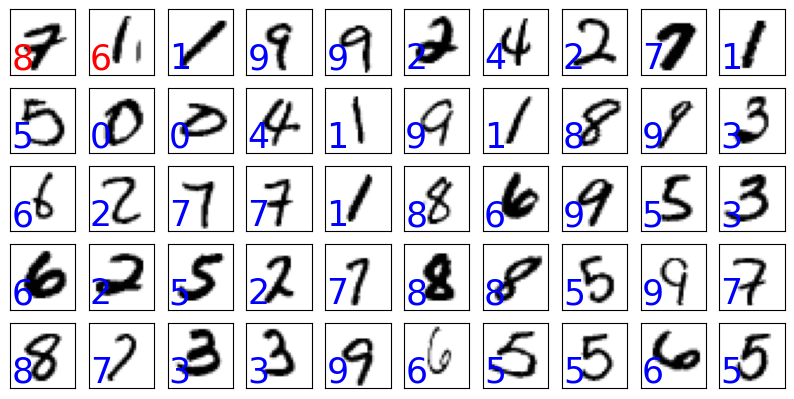

In [189]:
model_base.plot_predictions(test_dataset, 50)

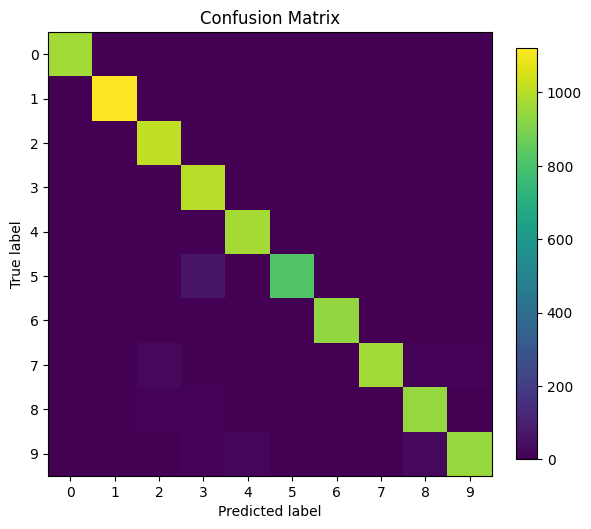

In [190]:
model_base.plot_confusion_matrix(test_dataset)

### Exercise 2: CNN

In [191]:
class CNN_Net(nn.Module):
    def __init__(self, activation="sigmoid"):
        super(CNN_Net, self).__init__()

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.flat = nn.Flatten()
        flat_dim = 32 * 7 * 7

        self.fc = nn.Linear(in_features=flat_dim, out_features=10)

        # network initialization
        self.apply(weight_init)

    def forward(self, input):
        # get back to image chape 1 x 28 x 28  (first dim = channels, =1 because grayscale)
        x = torch.reshape(input, (input.shape[0], int(math.sqrt(input.shape[1])), int(math.sqrt(input.shape[1]))))
        x = torch.unsqueeze(x,dim=1)
   
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = self.relu(self.conv3(x))
        x = self.flat(x)

        x = self.fc(x)

        return x

In [192]:
learning_rate = 0.01
epochs = 1
batch_size = 32

model_2 = CNN_Net(activation="relu")

model_cnn = train_model(model_2,
                        learning_rate,
                        batch_size,
                        epochs,
                        train_dataset,
                        test_dataset,
                        device='cpu')

Training:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch  0 - Step     0: train accuracy  15.62% train costs  2.30  test accuracy  10.52% test costs  2.31
Epoch  0 - Step   100: train accuracy  87.50% train costs  0.31  test accuracy  82.43% test costs  0.57
Epoch  0 - Step   200: train accuracy  93.75% train costs  0.22  test accuracy  90.95% test costs  0.30
Epoch  0 - Step   300: train accuracy  96.88% train costs  0.12  test accuracy  93.36% test costs  0.21
Epoch  0 - Step   400: train accuracy  93.75% train costs  0.24  test accuracy  93.90% test costs  0.20
Epoch  0 - Step   500: train accuracy  93.75% train costs  0.15  test accuracy  95.22% test costs  0.16
Epoch  0 - Step   600: train accuracy  93.75% train costs  0.18  test accuracy  96.18% test costs  0.13
Epoch  0 - Step   700: train accuracy 100.00% train costs  0.03  test accuracy  96.57% test costs  0.11
Epoch  0 - Step   800: train accuracy  96.88% train costs  0.14  test accuracy  95.68% test costs  0.14
Epoch  0 - Step   900: train accuracy  93.75% train costs  0.16 

Training: 100%|██████████| 1/1 [01:35<00:00, 95.33s/it]


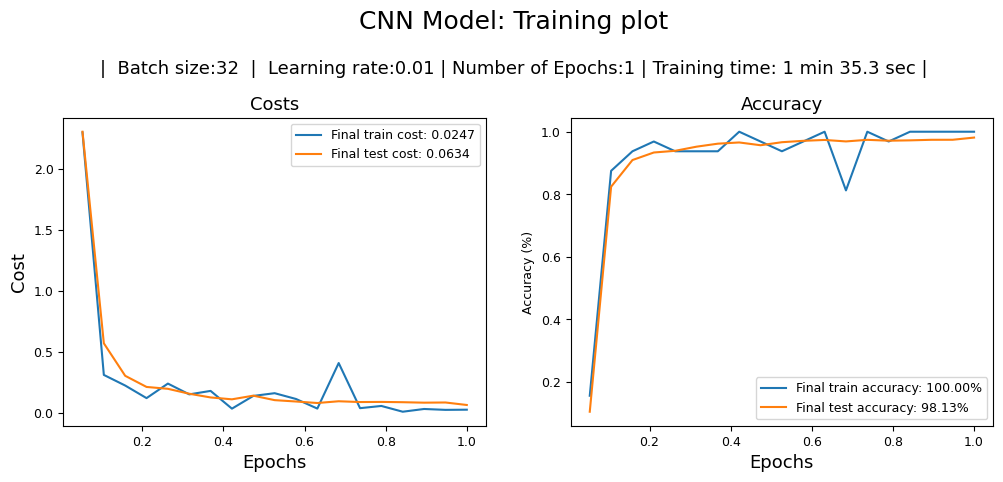

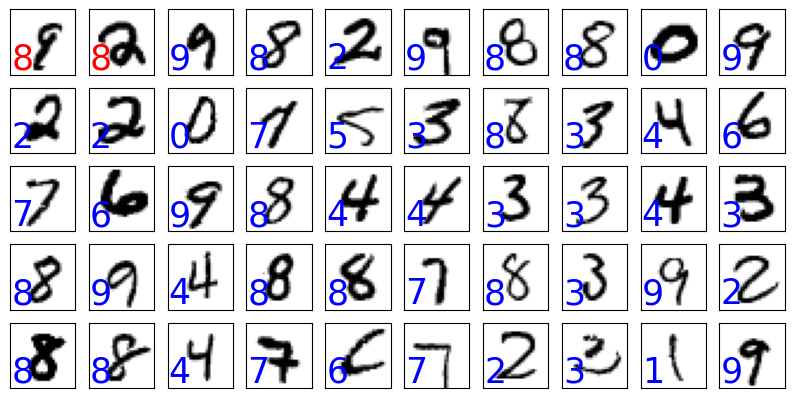

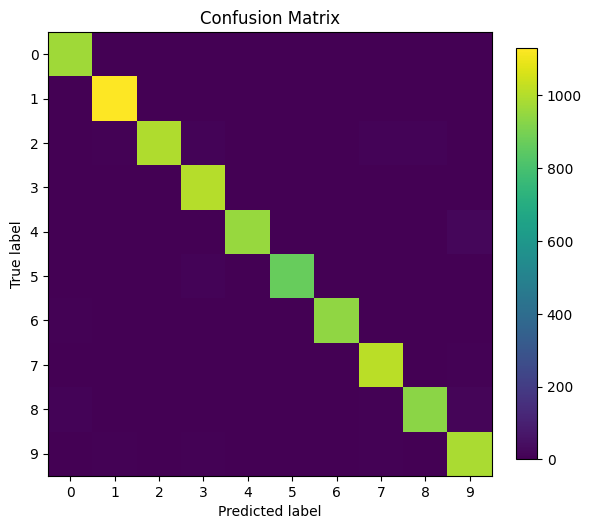

In [193]:
model_cnn.plot_loss_cost("CNN Model: Training plot")
model_cnn.plot_predictions(test_dataset, 50)
model_cnn.plot_confusion_matrix(test_dataset)

In [195]:
learning_rate = 0.001
epochs = 2
batch_size = 32

model_3 = CNN_Net()

model_cnn_adam = train_model(model_3,
                        learning_rate,
                        batch_size,
                        epochs,
                        train_dataset,
                        test_dataset,
                        device='cpu',
                        optimizer="Adam")

Training:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  0 - Step     0: train accuracy  18.75% train costs  2.30  test accuracy  10.28% test costs  2.30
Epoch  0 - Step   100: train accuracy  78.12% train costs  0.79  test accuracy  86.49% test costs  0.47
Epoch  0 - Step   200: train accuracy  81.25% train costs  0.75  test accuracy  91.76% test costs  0.29
Epoch  0 - Step   300: train accuracy  84.38% train costs  0.51  test accuracy  92.55% test costs  0.25
Epoch  0 - Step   400: train accuracy  93.75% train costs  0.55  test accuracy  93.24% test costs  0.21
Epoch  0 - Step   500: train accuracy 100.00% train costs  0.08  test accuracy  95.30% test costs  0.15
Epoch  0 - Step   600: train accuracy  96.88% train costs  0.07  test accuracy  96.46% test costs  0.12
Epoch  0 - Step   700: train accuracy  90.62% train costs  0.14  test accuracy  96.10% test costs  0.13
Epoch  0 - Step   800: train accuracy  90.62% train costs  0.19  test accuracy  96.46% test costs  0.11
Epoch  0 - Step   900: train accuracy  93.75% train costs  0.14 

Training:  50%|█████     | 1/2 [01:31<01:31, 91.92s/it]

Epoch  1 - Step  1900: train accuracy 100.00% train costs  0.01  test accuracy  98.14% test costs  0.06
Epoch  1 - Step  2000: train accuracy 100.00% train costs  0.01  test accuracy  98.09% test costs  0.06
Epoch  1 - Step  2100: train accuracy 100.00% train costs  0.02  test accuracy  97.96% test costs  0.06
Epoch  1 - Step  2200: train accuracy 100.00% train costs  0.03  test accuracy  98.34% test costs  0.05
Epoch  1 - Step  2300: train accuracy 100.00% train costs  0.01  test accuracy  98.29% test costs  0.05
Epoch  1 - Step  2400: train accuracy 100.00% train costs  0.04  test accuracy  98.35% test costs  0.05
Epoch  1 - Step  2500: train accuracy 100.00% train costs  0.04  test accuracy  98.56% test costs  0.04
Epoch  1 - Step  2600: train accuracy 100.00% train costs  0.02  test accuracy  98.54% test costs  0.05
Epoch  1 - Step  2700: train accuracy  93.75% train costs  0.08  test accuracy  98.44% test costs  0.05
Epoch  1 - Step  2800: train accuracy 100.00% train costs  0.04 

Training: 100%|██████████| 2/2 [03:05<00:00, 92.84s/it]


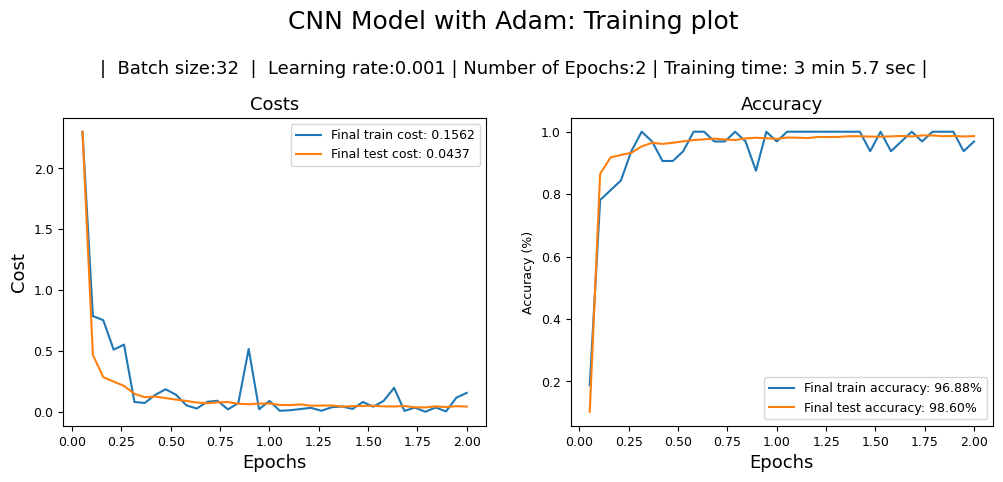

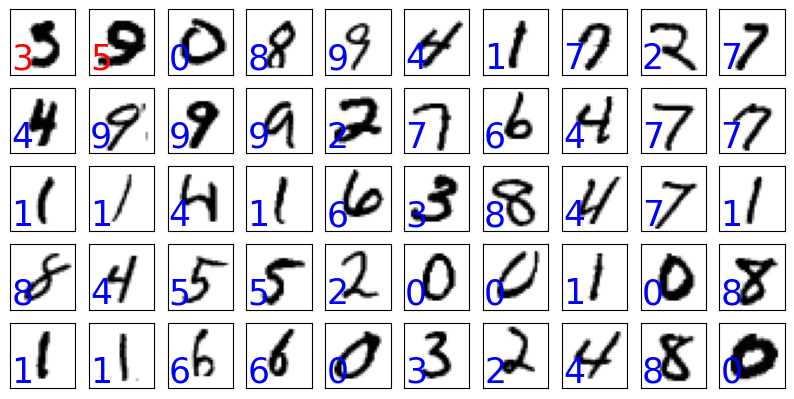

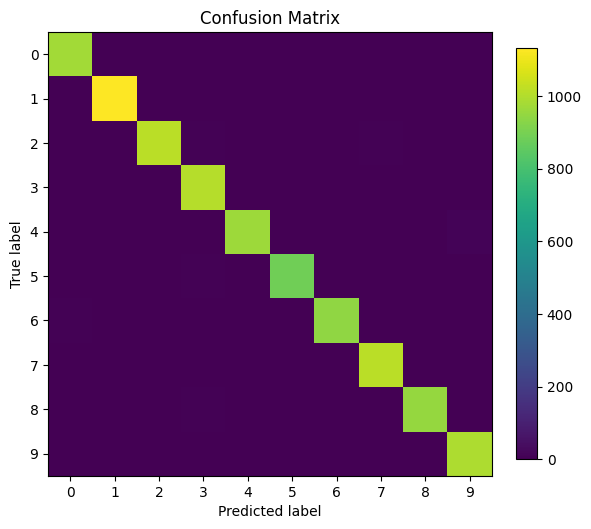

In [196]:
model_cnn_adam.plot_loss_cost("CNN Model with Adam: Training plot")
model_cnn_adam.plot_predictions(test_dataset, 50)
model_cnn_adam.plot_confusion_matrix(test_dataset)

###  Exercise 4. Residual connections
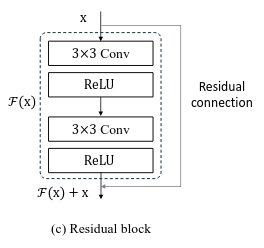

In [213]:
class CNN_Res_Net(nn.Module):
    def __init__(self, activation="sigmoid"):
        super(CNN_Res_Net, self).__init__()

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.flat = nn.Flatten()
        flat_dim = 32 * 28 * 28

        self.fc = nn.Linear(in_features=flat_dim, out_features=10)

        # network initialization
        self.apply(weight_init)

    def forward(self, input):
        # get back to image chape 1 x 28 x 28  (first dim = channels, =1 because grayscale)
        x = torch.reshape(input, (input.shape[0], int(math.sqrt(input.shape[1])), int(math.sqrt(input.shape[1]))))
        x = torch.unsqueeze(x,dim=1)

        residual = x

        x = self.conv1(x)
        #print(f"x.shape after conv1 = {x.shape}")

        x = self.relu(x)
        #print(f"x.shape after relu1 = {x.shape}")

        #x = self.pool(x)
        #print(f"x.shape after pool 1= {x.shape}")

        x = self.conv2(x)
        #print(f"x.shape after conv2 = {x.shape}")

        x = self.relu(x)
        #print(f"x.shape after relu2 = {x.shape}")

        #x = self.pool(x)
        #print(f"x.shape after pool2 = {x.shape}")


        #print(f">>RESIDUAL PART:\n >> x.shape = {x.shape} | residual.shape = {residual.shape}")
        x = x+residual
        #print(f">>RESIDUAL DONE:\n >> x.shape = {x.shape}")


        x = self.relu(self.conv3(x))
        #print(f"x.shape after conv3 & relu3 = {x.shape}")

        x = self.flat(x)
        #print(f"x.shape after flat = {x.shape}")


        x = self.fc(x)
        #print(f"x.shape after fc = {x.shape}")


        return x

In [ ]:
learning_rate = 0.001
epochs = 5
batch_size = 32

model_4 = CNN_Res_Net()

model_cnn_res = train_model(model_4,
                        learning_rate,
                        batch_size,
                        epochs,
                        train_dataset,
                        test_dataset,
                        device='cpu')

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch  0 - Step     0: train accuracy  15.62% train costs  2.33  test accuracy  11.52% test costs  2.32
Epoch  0 - Step   100: train accuracy  93.75% train costs  0.18  test accuracy  87.06% test costs  0.42
Epoch  0 - Step   200: train accuracy  90.62% train costs  0.36  test accuracy  88.87% test costs  0.38
Epoch  0 - Step   300: train accuracy  81.25% train costs  0.47  test accuracy  88.04% test costs  0.41
Epoch  0 - Step   400: train accuracy  84.38% train costs  0.54  test accuracy  89.65% test costs  0.34
Epoch  0 - Step   500: train accuracy  90.62% train costs  0.39  test accuracy  89.84% test costs  0.34
Epoch  0 - Step   600: train accuracy  90.62% train costs  0.22  test accuracy  89.03% test costs  0.37
Epoch  0 - Step   700: train accuracy  87.50% train costs  0.48  test accuracy  91.72% test costs  0.30
Epoch  0 - Step   800: train accuracy  93.75% train costs  0.23  test accuracy  90.87% test costs  0.31
Epoch  0 - Step   900: train accuracy  90.62% train costs  0.33 

Training:  20%|██        | 1/5 [02:58<11:54, 178.73s/it]

Epoch  1 - Step  1900: train accuracy  93.75% train costs  0.18  test accuracy  94.60% test costs  0.19
Epoch  1 - Step  2000: train accuracy 100.00% train costs  0.10  test accuracy  94.73% test costs  0.18
Epoch  1 - Step  2100: train accuracy  96.88% train costs  0.14  test accuracy  95.26% test costs  0.17
Epoch  1 - Step  2200: train accuracy  93.75% train costs  0.24  test accuracy  95.44% test costs  0.16
Epoch  1 - Step  2300: train accuracy  93.75% train costs  0.17  test accuracy  95.50% test costs  0.16
Epoch  1 - Step  2400: train accuracy  96.88% train costs  0.06  test accuracy  96.16% test costs  0.15
Epoch  1 - Step  2500: train accuracy  90.62% train costs  0.16  test accuracy  96.04% test costs  0.14
Epoch  1 - Step  2600: train accuracy  93.75% train costs  0.36  test accuracy  96.36% test costs  0.13
Epoch  1 - Step  2700: train accuracy  96.88% train costs  0.16  test accuracy  96.41% test costs  0.13
Epoch  1 - Step  2800: train accuracy  96.88% train costs  0.12 

In [ ]:
model_cnn_adam.plot_loss_cost("CNN Model with Adam: Training plot")
model_cnn_adam.plot_predictions(test_dataset, 50)
model_cnn_adam.plot_confusion_matrix(test_dataset)

### Archive


In [ ]:
class Model:
    def __init__(self, W, B):
        self.W = W
        self.B = B

In [ ]:
def initialize(K, D, D_i, D_o):
    W = [None] * (K+1)
    B = [None] * (K+1)

    if K == 0:
        W[0] = np.random.normal(0, np.sqrt(2 / D_i), size=(D_o, D_i))
        B[0] = np.random.normal(size =(D_o,1))

    else:
        #initialize first layer
        W[0] = np.random.normal(0, np.sqrt(2 / D_i), size=(D, D_i))
        B[0] = np.random.normal(size =(D,1))

        #hidden layers
        for layer in range(1,K):
            W[layer] = np.random.normal(0, np.sqrt(2 / D), size=(D, D)) #He initialization
            B[layer] = np.zeros((D,1))

        #last layer
        W[-1] = np.random.normal(0, np.sqrt(2 / D), size=(D_o, D))
        B[-1]= np.random.normal(size =(D_o,1))


    return W,B



In [ ]:
# W, B = initialize(K, D, D_i, D_o)
# model = Model(W, B)

#### 2. Activation functions

In [ ]:
def relu(x):
    activation = x.clip(0.0)
    return activation

def relu_der(x):
    dx = np.array(x)
    dx[dx>0] = 1
    dx[dx<=0] = 0
    return dx

def sigmoid(x):
    activation = 1.0 / (1.0 + np.exp(-x))
    return activation

def sigmoid_der(x):
    sigma = 1.0 / (1.0 + np.exp(-x))
    dx = sigma * (1.0 - sigma)
    return dx

#### 3. Forward pass

In [ ]:
def forward_pass(net_input, W, B, activation="relu"):

    K = len(W) -1 # number of layers

    F = [None] * (K+1) # pre-activations at each layer
    H = [None] * (K+1) # activations

    H[0] = net_input

    for layer in range(K):
        F[layer] = B[layer] + W[layer] @ H[layer]
        if activation == "relu":
            H[layer+1] = relu(F[layer])
        else:
            H[layer+1] = sigmoid(F[layer])

    F[K] = B[K] + W[K] @ H[K]

    net_output = F[K]

    return net_output, F, H

#### 4. Cost

In [ ]:
def softmax(x):

    shifted_x = x - np.max(x, axis=0, keepdims=True) # For numerical stability when f >> 0,preventing overflow of exp(x)

    exp_x = np.exp(shifted_x)
    probs = exp_x / np.sum(exp_x, axis=0, keepdims=True)

    return probs


def cross_entropy_cost(net_output, y):
    I = y.shape[1]  # Number of data points if data points as columns
    probs = softmax(net_output)
    out = np.sum(-1 * y * np.log(probs))/I # divided by I for numerical stability

    return out

def d_cost_d_output(net_output, y):
    I = y.shape[1] # Number of data points if data points as columns
    probs = softmax(net_output)
    out = (probs - y)/I # divided by I for numerical stability
    return out

#### 5. Backprop

In [ ]:
def backward_pass(W, B, F, H, y, activation="relu"):

    K = len(W)-1
    # We'll store the derivatives dl_dweights and dl_dbiases in lists as well
    dl_dW = [None] * (K+1)
    dl_dB = [None] * (K+1)
    # And we'll store the derivatives of the cost wrt the activation and preactivations in lists
    dl_df = [None] * (K+1)
    dl_dh = [None] * (K+1)
    # Again for convenience we'll stick with the convention that H[0] is the net input and F[k] in the net output

    #print("Backprop: ------------------------------")
    # Compute derivatives of the cost wrt the network output
    dl_df[K] = np.array(d_cost_d_output(F[K],y))
    #print(f"dl_df[{K}] shape: {dl_df[K].shape}")

    layer_range = np.flip(range(K+1))

    for layer in layer_range:
        # Calculate the derivatives of the cost wrt the biases at layer from dl_df[layer].
        dl_dB[layer] = np.sum(dl_df[layer], axis=1, keepdims=True)

        # Calculate the derivatives of the cost wrt the weights at layer from dl_df[layer] and H[layer]
        dl_dW[layer] = dl_df[layer] @ H[layer].T

        # Calculate the derivatives of cost wrt activations from weight and derivatives of next preactivations
        dl_dh[layer] =  W[layer].T @ dl_df[layer]

        if layer > 0:
            # Calculate derivatives of the cost wrt pre-activation f
            if activation=="relu":
                dl_df[layer-1] = relu_der(F[layer-1]) * dl_dh[layer]
            else:
                dl_df[layer-1] = sigmoid_der(F[layer-1]) * dl_dh[layer]



    return dl_dW, dl_dB

#### 6. Step & parameter update

In [ ]:
def update_parameters(W, B, dW, dB, lr):
    W_new = W - lr*dW
    B_new = B - lr*dB
    return W_new, B_new

#### 7. Predict

In [ ]:
def predict(model, x, y):

    res_logits, F, H = forward_pass(x.T, model.W, model.B)

    res = softmax(res_logits)

    # binarize
    # res_binary = np.where(res == np.max(res), 1,0)
    # acc = accuracy(y.T, res_binary)

    acc = accuracy(y.T, res)

    cost = cross_entropy_cost(res_logits, y.T)

    return res, acc, cost


def accuracy(y_true, y_pred):
    y_true_ind = np.argmax(y_true, axis=0)
    y_pred_ind = np.argmax(y_pred, axis=0)
    acc = np.mean(y_true_ind == y_pred_ind)

    return acc


#### 8. Mini-batch

In [ ]:
def random_mini_batches(x,y, size):
    assert len(x) == len(y)
    p = np.random.permutation(len(x))
    # x[p], y[p] are permuted arrays

    num_batches = math.ceil(len(x)/size)


    x_batched = np.array_split(x[p], num_batches)
    y_batched = np.array_split(y[p], num_batches)

    return x_batched, y_batched



#### 9. Model Training

In [ ]:

X_train, Y_train, X_test, Y_test = load_mnist()

In [ ]:
def train_model(X_train, Y_train, X_test, Y_test, model, activation, epochs, lr, batch_size):

    start = time.time()

    train_accuracies = np.zeros(epochs)
    test_accuracies = np.zeros(epochs)
    train_costs = np.zeros(epochs)
    test_costs = np.zeros(epochs)

    for epoch in range(epochs):

        X_batches, Y_batches = random_mini_batches(X_train, Y_train, batch_size)

        for X_batch, Y_batch in zip(X_batches, Y_batches):
            # Forward pass
            net_out, F, H = forward_pass(X_batch.T, model.W, model.B, activation)

            # Backward pass
            dl_dW, dl_dB = backward_pass(model.W, model.B, F, H, Y_batch.T, activation)

            # Update parameters layer by layer
            for k in range(len(model.W)):
                model.W[k], model.B[k] = update_parameters(
                    model.W[k], model.B[k],
                    dl_dW[k], dl_dB[k],
                    lr
                )

        # Evaluate after each epoch
        _, train_accuracies[epoch], train_costs[epoch] = predict(model, X_train, Y_train)
        _, test_accuracies[epoch], test_costs[epoch] = predict(model, X_test, Y_test)

        print(f"Epoch {epoch+1}/{epochs} "
              f"| Train acc: {train_accuracies[epoch]:.4f} "
              f"| Test acc: {test_accuracies[epoch]:.4f} "
              f"| Train cost: {train_costs[epoch]:.4f}"
              f"| Test cost: {test_costs[epoch]:.4f}")

    end = time.time()
    time_elapsed = end - start
    print(f"End of training. Time elapsed: {time_elapsed}")
    return model, train_accuracies, test_accuracies, train_costs, test_costs, time_elapsed


#### Linear Model

In [ ]:
# Number of hidden layers
K = 0
# Number of neurons per layer
D = 100
# Input layer dimension
D_i = 784
# Output layer dimension
D_o = 10

epochs = 15
lr = 0.005
batch = 10

W, B = initialize(K, D, D_i, D_o)
model_lin = Model(W, B)
mt_lin, train_acc_lin, test_acc_lin, train_cost_lin, test_costs_lin, time_lin = train_model(X_train,
                                                                                            Y_train, X_test,
                                                                                            Y_test,
                                                                                            model_lin,
                                                                                            epochs,
                                                                                            lr,
                                                                                            batch)

Epoch 1/15 | Train acc: 0.8787 | Test acc: 0.8862 | Train cost: 0.4520| Test cost: 0.4297
Epoch 2/15 | Train acc: 0.8929 | Test acc: 0.8996 | Train cost: 0.3872| Test cost: 0.3667
Epoch 3/15 | Train acc: 0.9005 | Test acc: 0.9079 | Train cost: 0.3592| Test cost: 0.3409
Epoch 4/15 | Train acc: 0.9045 | Test acc: 0.9108 | Train cost: 0.3424| Test cost: 0.3262
Epoch 5/15 | Train acc: 0.9081 | Test acc: 0.9122 | Train cost: 0.3309| Test cost: 0.3171
Epoch 6/15 | Train acc: 0.9103 | Test acc: 0.9145 | Train cost: 0.3222| Test cost: 0.3097
Epoch 7/15 | Train acc: 0.9123 | Test acc: 0.9150 | Train cost: 0.3160| Test cost: 0.3043
Epoch 8/15 | Train acc: 0.9132 | Test acc: 0.9169 | Train cost: 0.3104| Test cost: 0.3000
Epoch 9/15 | Train acc: 0.9152 | Test acc: 0.9170 | Train cost: 0.3059| Test cost: 0.2955
Epoch 10/15 | Train acc: 0.9158 | Test acc: 0.9181 | Train cost: 0.3021| Test cost: 0.2934
Epoch 11/15 | Train acc: 0.9170 | Test acc: 0.9177 | Train cost: 0.2986| Test cost: 0.2907
Epoch 12

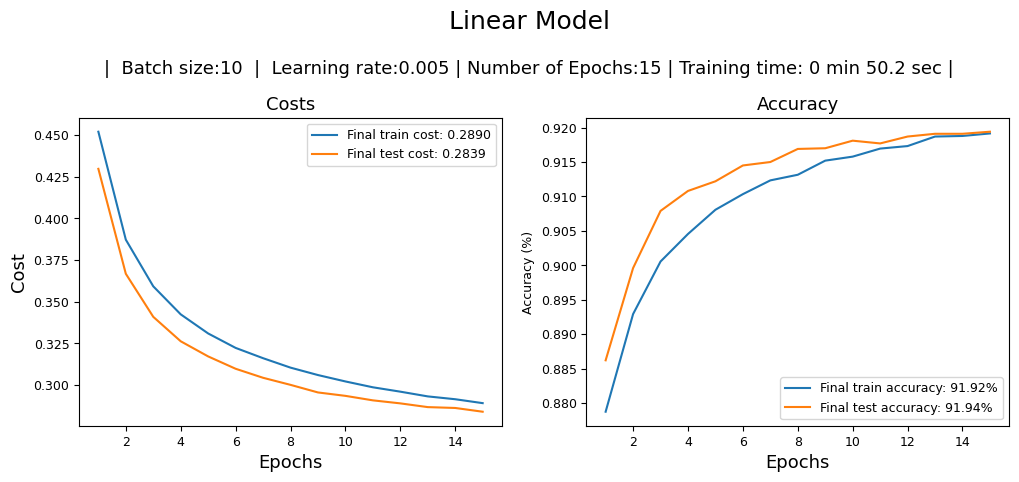

In [ ]:
training_curve_plot("Linear Model",
                    train_cost_lin,
                    test_costs_lin,
                    train_acc_lin,
                    test_acc_lin,
                    batch,
                    lr,
                    epochs,
                    time_lin)

#### Multilayer Model

In [ ]:
# Number of hidden layers
K = 4
# Number of neurons per layer
D = 200
# Input layer dimension
D_i = 784
# Output layer dimension
D_o = 10

W, B = initialize(K, D, D_i, D_o)
model_deep = Model(W, B)

epochs = 20
lr = 0.001
batch = 32
activation = "relu"

mt_deep, train_acc_deep, test_acc_deep, train_cost_deep, test_cost_deep, time_deep = train_model(X_train,
                                                                                                 Y_train,
                                                                                                 X_test,
                                                                                                 Y_test,
                                                                                                 model_deep,
                                                                                                 activation,
                                                                                                 epochs,
                                                                                                 lr,
                                                                                                 batch)

Epoch 1/20 | Train acc: 0.8333 | Test acc: 0.8434 | Train cost: 0.6369| Test cost: 0.6162
Epoch 2/20 | Train acc: 0.8768 | Test acc: 0.8850 | Train cost: 0.4336| Test cost: 0.4163
Epoch 3/20 | Train acc: 0.8939 | Test acc: 0.8990 | Train cost: 0.3668| Test cost: 0.3528
Epoch 4/20 | Train acc: 0.9037 | Test acc: 0.9080 | Train cost: 0.3320| Test cost: 0.3213
Epoch 5/20 | Train acc: 0.9106 | Test acc: 0.9164 | Train cost: 0.3072| Test cost: 0.2968
Epoch 6/20 | Train acc: 0.9139 | Test acc: 0.9189 | Train cost: 0.2906| Test cost: 0.2824
Epoch 7/20 | Train acc: 0.9191 | Test acc: 0.9232 | Train cost: 0.2728| Test cost: 0.2662
Epoch 8/20 | Train acc: 0.9244 | Test acc: 0.9281 | Train cost: 0.2591| Test cost: 0.2540
Epoch 9/20 | Train acc: 0.9268 | Test acc: 0.9289 | Train cost: 0.2483| Test cost: 0.2451
Epoch 10/20 | Train acc: 0.9301 | Test acc: 0.9306 | Train cost: 0.2397| Test cost: 0.2376
Epoch 11/20 | Train acc: 0.9320 | Test acc: 0.9333 | Train cost: 0.2327| Test cost: 0.2318
Epoch 12

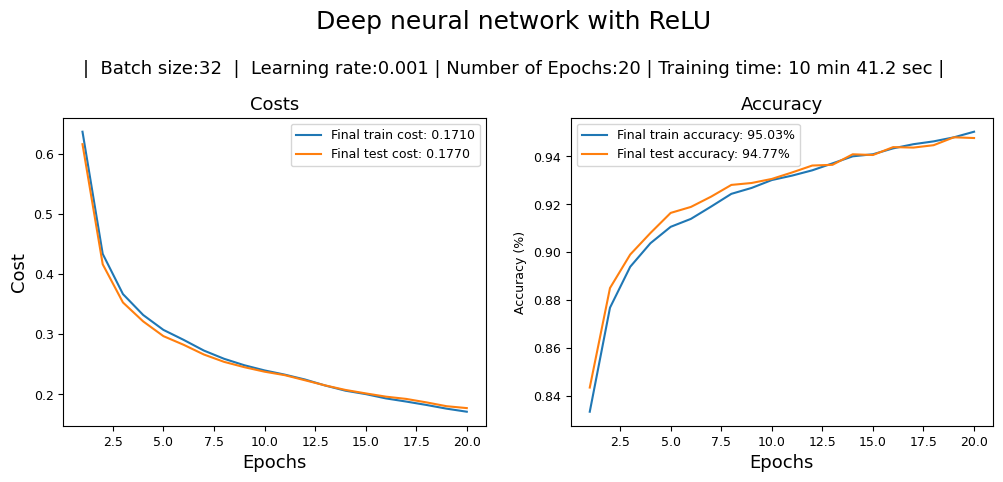

In [ ]:
training_curve_plot("Deep neural network with ReLU",
                    train_cost_deep,
                    test_cost_deep,
                    train_acc_deep,
                    test_acc_deep,
                    batch,
                    lr,
                    epochs,
                    time_deep)


In [ ]:
mt_deep.W

[array([[-0.0096289 ,  0.01649875,  0.04959741, ...,  0.04111809,
         -0.00348419,  0.02128222],
        [ 0.10522857, -0.00935686, -0.05216326, ...,  0.03775482,
         -0.04547537, -0.04576394],
        [ 0.06811456,  0.08127318, -0.06021326, ...,  0.03556794,
          0.00617658, -0.01200848],
        ...,
        [-0.0075611 , -0.04209449, -0.00840711, ...,  0.08521895,
          0.08145824,  0.02979124],
        [ 0.03152796,  0.00385456,  0.01776257, ..., -0.04475326,
          0.02086562, -0.09210897],
        [ 0.01698151, -0.02477337, -0.04655505, ...,  0.10259134,
          0.07994832,  0.00217788]], shape=(200, 784)),
 array([[ 0.20460722, -0.10732621,  0.06117268, ...,  0.04101639,
          0.04733004,  0.02964867],
        [-0.0663169 ,  0.0568399 ,  0.02398108, ...,  0.0007904 ,
         -0.20259983, -0.18005245],
        [ 0.04393739,  0.09379887,  0.1227545 , ..., -0.01121743,
         -0.03302019,  0.09684684],
        ...,
        [-0.22850074,  0.09433658,  

In [ ]:
type(mt_deep.W[0])

numpy.ndarray

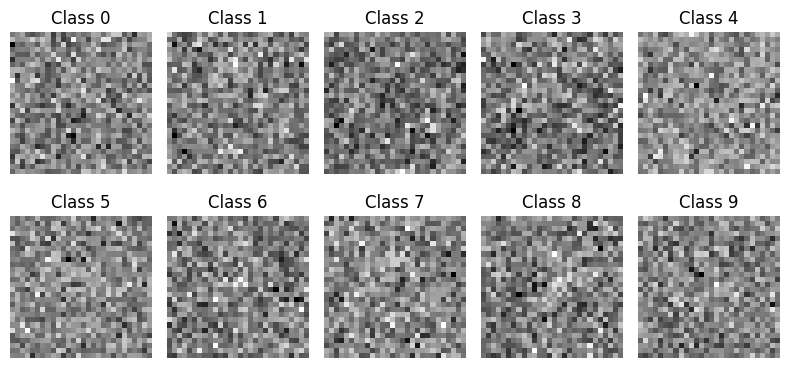

In [ ]:
plt.figure(figsize=(8, 4))

for i in range(10):
    plt.subplot(2, 5, i + 1)            # 2 rows, 5 columns
    img = mt_deep.W[0][i].reshape(28, 28)          # reshape row to 28×28
    plt.imshow(img, cmap='gray')
    plt.title(f"Class {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

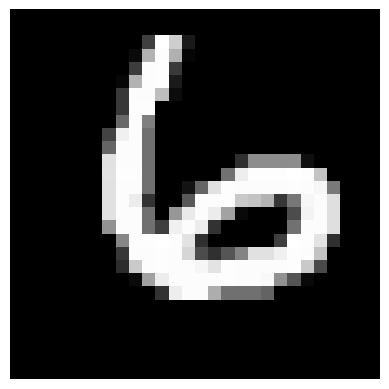

In [ ]:


# take first training sample
img = sample.reshape(28, 28)

plt.imshow(img, cmap='gray')
plt.axis('off')   # hide axes
plt.show()

In [ ]:
# Number of hidden layers
K = 5
# Number of neurons per layer
D = 100
# Input layer dimension
D_i = 784
# Output layer dimension
D_o = 10

W, B = initialize(K, D, D_i, D_o)
model_deep2 = Model(W, B)

epochs = 20
lr = 0.001
batch = 32
activation = "sigmoid"

mt_deep2, train_acc_deep2, test_acc_deep2, train_cost_deep2, test_cost_deep2, time_deep2 = train_model(X_train,
                                                                                                 Y_train,
                                                                                                 X_test,
                                                                                                 Y_test,
                                                                                                 model_deep2,
                                                                                                 activation,
                                                                                                 epochs,
                                                                                                 lr,
                                                                                                 batch)

Epoch 1/20 | Train acc: 0.0828 | Test acc: 0.0855 | Train cost: 2.4066| Test cost: 2.4062
Epoch 2/20 | Train acc: 0.0843 | Test acc: 0.0881 | Train cost: 2.4041| Test cost: 2.4036
Epoch 3/20 | Train acc: 0.0823 | Test acc: 0.0857 | Train cost: 2.4022| Test cost: 2.4015
Epoch 4/20 | Train acc: 0.0823 | Test acc: 0.0853 | Train cost: 2.4006| Test cost: 2.3999


In [ ]:
training_curve_plot("Deep neural network with ReLU",
                    train_cost_deep2,
                    test_cost_deep2,
                    train_acc_deep2,
                    test_acc_deep2,
                    batch,
                    lr,
                    epochs,
                    time_deep2)
